<a href="https://colab.research.google.com/github/taizifufeng/fastbook/blob/master/%E2%80%9Ciml_main_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ itsmhkapoor/triplet-loss-same: 演示了一个三重损失来计算三幅图像之间的关系，当一幅图像与另一幅图像相似而与第三幅图像不同时。]( https://github.com/itsmhkapoor/triplet-loss-similarity )

自述文件 [triplet-loss-similarity/README.md at main · itsmhkapoor/triplet-loss-similarity](https://github.com/itsmhkapoor/triplet-loss-similarity/blob/main/README.md)

ResNet50

pandas

tensorflow

### Mount Drive

skimage即是Scikit-Image。基于python脚本语言开发的数字图片处理包，比如PIL,Pillow, opencv, scikit-image等。

PIL和Pillow只提供最基础的数字图像处理，功能有限。
opencv实际上是一个c++库，只是提供了python接口，更新速度非常慢。
scikit-image是基于scipy的一款图像处理包，它将图片作为numpy数组进行处理，正好与matlab一样，因此，我们最终选择scikit-image进行数字图像处理。
————————————————
版权声明：本文为CSDN博主「我与懒惰作斗争的日子」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/qq_39437730/article/details/117994355



```
#requirements.txt
#pandas==1.4.1
matplotlib==3.5.1
numpy==1.21.5
scikit_learn==1.1.1
tensorflow==2.9.1
tqdm==4.62.3
scikit-image
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -r /content/sample_data/requirements

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/sample_data/requirements'


### Import Libraries

In [ ]:
import os
import glob
import csv 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from skimage import io, transform

from numpy.linalg import norm 
import matplotlib.pyplot as plt 

import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.layers import Input,Embedding,LSTM,Dense
from keras.models import Model
from keras import backend as K

该模型在私有数据集上进行了训练和测试。训练三元组在 .txt 文件中给出，格式为 'anchor_image_name positive_image_name negative_image_name'，另一个文件中的测试三元组也是如此。作为预处理步骤，所有图像的大小都调整为 224x224（ResNet50 的输入大小）。

[(5条消息) 【Pandas总结】第二节 Pandas 的数据读取_pd.read_csv()的使用详解（非常全面，推荐收藏）_这么神奇的博客-CSDN博客](https://blog.csdn.net/weixin_47139649/article/details/126744842)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/image/txt/train_triplets.txt', header=None, sep=' ', dtype='str')
test = pd.read_csv('/content/drive/MyDrive/image/txt/test_triplets.txt', header=None, sep=' ', dtype='str')
train.columns = ['img', 'img1', 'img2']
test.columns = ['img', 'img1', 'img2']

print (train.shape, test.shape)

train.head(100)

(256, 3) (256, 3)


,img,img1,img2
0,01(1),01(1),43(1)
1,02(1),02(1),52(1)
2,03(1),03(1),51(1)
3,04(1),04(1),54(1)
4,05(1),05(1),55(1)
...,...,...,...
95,d8,d8,d2
96,e1,e1,e5
97,e2,e2,e8
98,e3,e3,e6


### Load Images and Train-Validation Split

加载图像和训练验证拆分

In [ ]:
allow_val_overlap = True

#定义了两个函数
#get_data(两个输入)
def get_data(df, ids): 
    #select(三个输入)
    def select(x, y, z):
        if x in ids and y in ids and z in ids:
            return True
        return False
    dat = df.copy() #复制df
    #lambda函数也叫匿名函数，即没有具体名称的函数，它允许快速定义单行函数，可以用在任何需要函数的地方。这区别于def定义的函数。
    dat['Select'] = dat[['img', 'img1', 'img2']].apply(lambda x: select(x['img'], x['img1'], x['img2']), axis=1)
    return df[dat['Select']==True]

In [ ]:

if allow_val_overlap:
  #拆分训练集和验证集
    x_train, x_val = train_test_split(train, shuffle=True, random_state=2019, test_size=0.2)
else:
    temp = np.unique(train[['img', 'img1', 'img2']].values) 
    #对于一维数组或者列表
    #np.unique() 函数去除其中重复的元素 ，并按元素由小到大 返回一个新的无元素重复的元组或者列表。
    np.random.seed(643)
    ids = np.random.randint(0, len(temp), size=1500)
    tids = temp[~np.isin(np.arange(len(temp)), ids)]
    vids = temp[ids]

    trn = get_data(train, tids)
    val = get_data(train, vids)
    x_train = trn
    x_val = val

img_dir = '/content/drive/MyDrive/image/' # write image directory path

imgs = {}
#glob.glob()返回所有匹配的文件路径列表。只有一个参数pathname，定义了文件路径匹配规则

for file in glob.glob(img_dir+'*.png'):
    img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img) 
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) 
    imgs[os.path.basename(file)[:-4]] = np.squeeze(img)

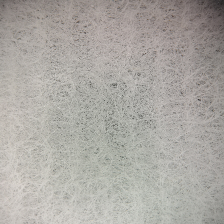

In [ ]:
img1 = tf.keras.preprocessing.image.load_img(img_dir+'78(1).png', target_size=(224, 224))
#img = tf.keras.preprocessing.image.img_to_array(img) 
#img = np.expand_dims(img, axis=0)
#img = preprocess_input(img)
#img = np.squeeze(img)
img1
#imgs

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=4, inp_dim=(224, 224, 3), n_classes=2, shuffle=True):
        self.inp_dim = inp_dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X1, X2, X3, y = self.__data_generation(list_IDs_temp)
        return [X1, X2, X3], y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X1 = []
        X2 = []
        X3 = []
        y = np.empty((self.batch_size), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            record = ID 
            X1.append(imgs[record[0]])
            X2.append(imgs[record[1]])
            X3.append(imgs[record[2]])
            y[i] = 1
        return np.array(X1), np.array(X2), np.array(X3), y
#生成训练集和验证集
training_generator = DataGenerator(x_train.values, batch_size=64, n_classes=2, shuffle=True)
validation_generator = DataGenerator(x_val.values, batch_size=64, n_classes=2, shuffle=True)
#最后的预测集
testing_generator = DataGenerator(test.values, batch_size=64, n_classes=2, shuffle=False)

In [ ]:
#training_generator.list_IDs

array([['B26', 'B26', 'B66'],
       ['S47', 'S47', 'S07'],
       ['S52', 'S52', 'S12'],
       ['06(1)', '06(1)', '51(1)'],
       ['45(1)', '45(1)', '41(1)'],
       ['B51', 'B51', 'B11'],
       ['76(1)', '76(1)', '03(1)'],
       ['B05', 'B05', 'B45'],
       ['25(1)', '25(1)', '71(1)'],
       ['23(1)', '23(1)', '74(1)'],
       ['51(1)', '51(1)', '01(1)'],
       ['B02', 'B02', 'B42'],
       ['42(1)', '42(1)', '48(1)'],
       ['44(1)', '44(1)', '47(1)'],
       ['S37', 'S37', 'S77'],
       ['S51', 'S51', 'S11'],
       ['77(1)', '77(1)', '07(1)'],
       ['B33', 'B33', 'B73'],
       ['B24', 'B24', 'B64'],
       ['S23', 'S23', 'S63'],
       ['h2', 'h2', 'h8'],
       ['B17', 'B17', 'B57'],
       ['g6', 'g6', 'g1'],
       ['S17', 'S17', 'S57'],
       ['S28', 'S28', 'S68'],
       ['08(1)', '08(1)', '01(1)'],
       ['h6', 'h6', 'h1'],
       ['B48', 'B48', 'B08'],
       ['S45', 'S45', 'S05'],
       ['h8', 'h8', 'h2'],
       ['c6', 'c6', 'c3'],
       ['B58', 'B58', 'B1

In [ ]:
#validation_generator.list_IDs

array([['h3', 'h3', 'h6'],
       ['05(1)', '05(1)', '55(1)'],
       ['43(1)', '43(1)', '44(1)'],
       ['b5(1)', 'b5(1)', 'b2(1)'],
       ['S54', 'S54', 'S14'],
       ['d1', 'd1', 'd2'],
       ['B78', 'B78', 'B38'],
       ['b4(1)', 'b4(1)', 'b3(1)'],
       ['57(1)', '57(1)', '58(1)'],
       ['h4', 'h4', 'h3'],
       ['28(1)', '28(1)', '26(1)'],
       ['S43', 'S43', 'S03'],
       ['B16', 'B16', 'B56'],
       ['g7', 'g7', 'g6'],
       ['71(1)', '71(1)', '72(1)'],
       ['B36', 'B36', 'B76'],
       ['13(1)', '13(1)', '14(1)'],
       ['c2', 'c2', 'c8'],
       ['B35', 'B35', 'B75'],
       ['B13', 'B13', 'B53'],
       ['B54', 'B54', 'B14'],
       ['d7', 'd7', 'd1'],
       ['B04', 'B04', 'B44'],
       ['01(1)', '01(1)', '43(1)'],
       ['f8', 'f8', 'f2'],
       ['B56', 'B56', 'B16'],
       ['63', '63', '66'],
       ['S16', 'S16', 'S56'],
       ['B52', 'B52', 'B12'],
       ['B11', 'B11', 'B51'],
       ['07(1)', '07(1)', '53(1)'],
       ['B65', 'B65', 'B25'],
    

In [ ]:
#testing_generator.list_IDs

array([['01(1)', '01(1)', '43(1)'],
       ['02(1)', '02(1)', '52(1)'],
       ['03(1)', '03(1)', '51(1)'],
       ['04(1)', '04(1)', '54(1)'],
       ['05(1)', '05(1)', '55(1)'],
       ['06(1)', '06(1)', '51(1)'],
       ['07(1)', '07(1)', '53(1)'],
       ['08(1)', '08(1)', '01(1)'],
       ['11(1)', '11(1)', '17(1)'],
       ['12(1)', '12(1)', '22(1)'],
       ['13(1)', '13(1)', '14(1)'],
       ['14(1)', '14(1)', '15(1)'],
       ['15(1)', '15(1)', '11(1)'],
       ['16(1)', '16(1)', '13(1)'],
       ['17(1)', '17(1)', '18(1)'],
       ['18(1)', '18(1)', '16(1)'],
       ['21(1)', '21(1)', '22(1)'],
       ['22(1)', '22(1)', '71(1)'],
       ['23(1)', '23(1)', '74(1)'],
       ['24(1)', '24(1)', '75(1)'],
       ['25(1)', '25(1)', '71(1)'],
       ['26(1)', '26(1)', '23(1)'],
       ['27(1)', '27(1)', '28(1)'],
       ['28(1)', '28(1)', '26(1)'],
       ['31', '31', '35'],
       ['32', '32', '38'],
       ['33', '33', '36'],
       ['34', '34', '33'],
       ['35', '35', '34'],
 

### Losses 重点

In [ ]:
loss_p = 2 # 1, 2 or cosine（余弦）
metric_p = 2 # 1, 2 or cosine

#定义损失函数(实际值，预测值，，)
def triplet_loss(y_true, y_pred, alpha=0.9, p=loss_p):
  
    total_length = y_pred.shape.as_list()[-1] #取出预测值的
    anc = y_pred[:, 0:int(total_length*1/3)] #基准
    pos = y_pred[:, int(total_length*1/3):int(total_length*2/3)] #正例
    neg = y_pred[:, int(total_length*2/3):int(total_length*3/3)] #负例
    
    # 欧式距离（L2范数）
    pos_dist = K.sum(K.square(anc - pos), axis=-1, keepdims=True)#正例的距离
    neg_dist = K.sum(K.square(anc - neg), axis=-1, keepdims=True)#负例的距离
    basic_loss = pos_dist - neg_dist + alpha 
    #alpha margin参数 拉大了Anchor和Positive图片对和Anchor与Negative 图片对之间的差距
    #margin是一个常数。
    loss = K.maximum(basic_loss, 0.0)

    #print "[INFO] model - triplet_loss shape: %s" % str(loss.shape)
    return loss

    #if p == 1:
        #pos_dist = tf.keras.backend.mean(tf.keras.backend.abs(anc - pos))
        #neg_dist = tf.keras.backend.mean(tf.keras.backend.abs(anc - neg))
        #basic_loss = pos_dist - neg_dist + alpha
        #loss = tf.keras.backend.maximum(basic_loss, 0.0)
        #return loss
    #elif p == 'cosine':
        #distance1 = tf.keras.losses.cosine_similarity(anc, pos)
        #distance2 = tf.keras.losses.cosine_similarity(anc, neg)
        #loss = tf.keras.backend.maximum(distance1 - distance2 + alpha, 0.0)
        #return loss
    #else:
        #assert p == 2, 'p can be 1, 2 or cosine'
        #pos_dist = tf.keras.backend.mean(tf.keras.backend.square(anc - pos))
        #neg_dist = tf.keras.backend.mean(tf.keras.backend.square(anc- neg))
        #basic_loss = pos_dist - neg_dist + alpha
        #loss = tf.keras.backend.maximum(basic_loss, 0.0)
        #return loss

#计算准确度的函数()
#y_true 是结果集，y_pred 是预测集
def accuracy(y_true, y_pred, p=metric_p,alpha=0.9):
    total_length = y_pred.shape.as_list()[-1]
    anchor = y_pred[:, 0:int(total_length*1/3)]
    positive = y_pred[:, int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:, int(total_length*2/3):int(total_length*3/3)]

    if p == 1 or p == 2:
    #pos_dist = K.sum(K.square(anchor - positive), axis=-1, keepdims=True)
    #neg_dist = K.sum(K.square(anchor - negative), axis=-1, keepdims=True)
        pos_dist = tf.linalg.norm((anchor - positive), ord=p, axis=1) 
        neg_dist = tf.linalg.norm((anchor - negative), ord=p, axis=1)
    #else:
        #normalize_a = tf.math.l2_normalize(anchor, axis=1)
        #normalize_b = tf.math.l2_normalize(positive, axis=1)        
        #normalize_c = tf.math.l2_normalize(negative, axis=1)        
        #pos_dist = -tf.matmul(normalize_a, normalize_b, transpose_b=True)
        #neg_dist = -tf.matmul(normalize_a, normalize_c, transpose_b=True)
    
    preds = tf.cast(np.float(pos_dist<alpha)*0.25+np.float(neg_dist>alpha)*0.75, tf.float32)
    #labels = tf.cast(pos_dist < neg_dist, tf.float32) #数据类型转换
    #labels = tf.cast(preds>0.7, tf.float32)
    acc = tf.keras.metrics.binary_accuracy(y_true, preds)

    return acc

def seed(seed=643):
    np.random.seed(seed)
    tf.random.set_seed(seed)

[(5条消息) tf.keras.metrics.BinaryAccuracy函数_不负韶华ღ的博客-CSDN博客](https://blog.csdn.net/weixin_49346755/article/details/124524923)

BinaryAccuracy函数用于计算二分类问题的准确率。

binary_accuracy的计算除了y_true和y_pred外，还有一个threshold参数，该参数默认为0.5。比如有6个样本，其y_true为[0, 0, 0, 1, 1, 0]，y_pred为[0.2, 0.3, 0.6, 0.7, 0.8, 0.1]，那么其binary_accuracy=5/6=87.5%。

具体计算方法为：
1）将y_pred中的每个预测值和threshold对比，大于threshold的设为1，小于等于threshold的设为0，得到y_pred_new=[0, 0, 1, 1, 1, 0]；
2）将y_true和y_pred_new代入到2.1中计算得到最终的binary_accuracy=87.5%。


### Train Final Layer

训练最后一层

In [ ]:
encoding_size = 20
input_dim = 2048

#设置优化器
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

seed()
#l2_normalize函数
#tf.nn.l2_normalize(x, dim, epsilon=1e-12, name=None)
#解释：这个函数的作用是利用 L2 范数对指定维度 dim 进行标准化。
class L2Normalize(tf.keras.layers.Layer):
    def __init__(self, axis=1):
        super(L2Normalize, self).__init__()
        self.axis = axis
    def call(self, inputs):
        return tf.keras.backend.l2_normalize(inputs, axis=self.axis)
#特征提取
#我们的任务不是分类任务，因此我们不使用完整的 ResNet-50 架构。
#ResNet-50 直到倒数第二层（'avg_pool' 层）用于特征提取（基础模型），这是在 ImageNet 数据集上预训练的。
base_model = ResNet50(weights='imagenet') 
last_layer = base_model.get_layer('avg_pool')

x = last_layer.output
x = tf.keras.layers.Dropout(0.2)(x) 
#防止过拟合，tf.keras.layers.Dropout可以按照一定频率，随机地将输入的中的一些节点数值设置为0，防止过拟合。

x = tf.keras.layers.Dense(input_dim//2, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
out = tf.keras.layers.Dense(encoding_size)(x)
out = L2Normalize(axis=1)(out)

for layer in base_model.layers:
    layer.trainable = False
Net = tf.keras.Model(base_model.input, out)    

#正例
anchor_input = tf.keras.layers.Input((224, 224, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((224, 224, 3), name='positive_input')
negative_input = tf.keras.layers.Input((224, 224, 3), name='negative_input')

encoded_anchor = Net(anchor_input)
encoded_positive = Net(positive_input)
encoded_negative = Net(negative_input)
merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')


In [ ]:
anchor_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'anchor_input')>

In [ ]:
#加载模型
model = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=opt, metrics=[accuracy])
#model.compile()方法用于在配置训练方法时，告知训练时用的优化器、损失函数和准确率评测标准
#使用keras构建深度学习模型，我们会通过model.summary()输出模型各层的参数状况
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                          

`KeyError Traceback (most recent call last)`
回溯（最近的一次呼叫）

这里表示您的Python程序出现了异常，括号中通俗的解释就是代码中引发异常的位置。

model.fit()方法用于执行训练过程

```
#第五步，model.fit()
model.fit(  #使用model.fit()方法来执行训练过程，
    x_train, y_train, #告知训练集的输入以及标签，
    batch_size = 32, #每一批batch的大小为32，
    epochs = 500, #迭代次数epochs为500
    validation_data = (测试集的输入特征，测试集的标签）
    validation_split = 0.2, #从测试集中划分80%给训练集
    validation_freq = 20 #测试的间隔次数为20
```
[(5条消息) tensorflow中model.fit()用法_yunfeather的博客-CSDN博客](https://blog.csdn.net/yunfeather/article/details/106463327)

In [ ]:
history = model.fit(training_generator, validation_data=validation_generator, batch_size=64, epochs=300)

Epoch 1/300


/tmp/__autograph_generated_file634ni2he.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preds = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(np).float, (ag__.ld(pos_dist) < ag__.ld(alpha),), None, fscope) * 0.25 + ag__.converted_call(ag__.ld(np).float, (ag__.ld(neg_dist) > ag__.ld(alpha),), None, fscope) * 0.75, ag__.ld(tf).float32), None, fscope)


4/4 [==============================] - 210s 45s/step - loss: 0.8205 - accuracy: 0.6250 - val_loss: 0.6912 - val_accuracy: 0.0192
Epoch 2/300
4/4 [==============================] - 167s 43s/step - loss: 0.8104 - accuracy: 0.8698 - val_loss: 0.6443 - val_accuracy: 0.0192
Epoch 3/300
4/4 [==============================] - 165s 42s/step - loss: 0.7857 - accuracy: 0.8763 - val_loss: 0.6191 - val_accuracy: 0.0385
Epoch 4/300
4/4 [==============================] - 162s 39s/step - loss: 0.7556 - accuracy: 0.9206 - val_loss: 0.6080 - val_accuracy: 0.0385
Epoch 5/300
4/4 [==============================] - 156s 39s/step - loss: 0.7098 - accuracy: 0.9089 - val_loss: 0.5769 - val_accuracy: 0.0769
Epoch 6/300
4/4 [==============================] - 163s 42s/step - loss: 0.7039 - accuracy: 0.9219 - val_loss: 0.5525 - val_accuracy: 0.1346
Epoch 7/300
4/4 [==============================] - 173s 55s/step - loss: 0.6532 - accuracy: 0.9375 - val_loss: 0.5224 - val_accuracy: 0.1538
Epoch 8/300
4/4 [========

KeyboardInterrupt: ignored

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
model.compile(loss=triplet_loss, optimizer=opt, metrics=[accuracy])
#model.summary()
history = model.fit(training_generator, validation_data=validation_generator, batch_size=64, epochs=10)

### Fine-tune the Base Model

微调基础模型

In [ ]:
fine_tune = False #微调开关

if fine_tune:
    unfreeze = False
    for layer in base_model.layers:
        if unfreeze:
            layer.trainable = True
        if layer.name == 'conv4_block6_out':
            print ('Unfreezing last layers')
            unfreeze = True

    opt = tf.keras.optimizers.Adam(lr=0.00001)
    model.compile(loss=triplet_loss, optimizer=opt, metrics=[accuracy])
    history2 = model.fit(training_generator, validation_data=validation_generator, batch_size=64, epochs=50)

### Predict on Test Images

预测测试图像

In [ ]:
k = 0 #开关
#更改txt文件 加载新的预测对象

if k==1
  test = pd.read_csv('/content/drive/MyDrive/image/txt/test_triplets.txt', header=None, sep=' ', dtype='str')
  test.columns = ['img', 'img1', 'img2']
  print (test.shape，testing_generator.list_IDs)
  testing_generator = DataGenerator(test.values, batch_size=64, n_classes=2, shuffle=False)

In [ ]:
test_emb = model.predict(testing_generator, batch_size=64, verbose=1)

In [ ]:
metric_p = 2
def emb2labels(y_pred, p=metric_p, alpha=0.8):
    total_length = y_pred.shape[-1]
    anchor = y_pred[:, 0:int(total_length*1/3)]
    positive = y_pred[:, int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:, int(total_length*2/3):int(total_length*3/3)]
    if p == 1 or p == 2:
        pos_dist = np.linalg.norm((anchor - positive), ord=p, axis=1) 
        neg_dist = np.linalg.norm((anchor - negative), ord=p, axis=1)
    else:
        normalize_a = tf.math.l2_normalize(anchor, axis=1)
        normalize_b = tf.math.l2_normalize(positive, axis=1)        
        normalize_c = tf.math.l2_normalize(negative, axis=1)        
        pos_dist = -tf.matmul(normalize_a, normalize_b, transpose_b=True)
        neg_dist = -tf.matmul(normalize_a, normalize_c, transpose_b=True)
    #labels = (pos_dist < neg_dist).astype('int32')
    print((pos_dist<alpha))
    print((neg_dist>alpha))
    labels = (pos_dist>alpha).astype('int32')*0.25+(neg_dist<alpha).astype('int32')*0.75
    print(labels)
    return labels

test_pred = emb2labels(test_emb)

### Plots

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot(111)
plt.plot(history.history['accuracy'], label='Loss')
plt.title('Train Accuracy')
plt.grid()

plt.subplot(122)
plt.plot(history.history['val_accuracy'], label='Loss')
plt.title('Validation Accuracy')
plt.grid()

plt.show()

`ImageGrid()`函数参数说明：nrows_ncols=(1,3)表示创建一个1行3列的画布。share_all=True表示所画的图像公用x坐标轴和y坐标轴。cbar_location="right"表示colorbar位于图像的右侧，当然也可以位于上方，下方和左侧。cbar_mode="single"表示三个图像公用一个colorbar。


In [ ]:
test_pred[0]

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 10*5))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 3), axes_pad=0.4)

im = []
#for i in [1, 10, 2000, 6000, 10000, 15000, 20000, 25000, 40000, 50000]:
for i in [1,2,3,4,5,6,7,8]:
    lab = test_pred[i]
    if lab == 0:
        text = '都搞错了'
        text1 = 'Fake0'
        text2 = 'True0'
    elif lab == 0.25:
        text = '真的没认出来'
        text1 = 'True0.25'
        text2 = 'True0.25'
    elif lab == 0.75:
        text =  '假的没认出来'
        text1 == 'Fake0.75'
        text2 == 'Fake0.75' 
    elif lab == 1:
        text = '都认出来了'
        text1 = 'True0.75'
        text2 = 'Fake0.75'
    im.append((io.imread(img_dir+test.iloc[i]['img']+'.png'), text))
    im.append((io.imread(img_dir+test.iloc[i]['img1']+'.png'), text1))
    im.append((io.imread(img_dir+test.iloc[i]['img2']+'.png'), text2))

for ax, im in zip(grid, im):
    ax.imshow(im[0])
    ax.set_title(im[1])
plt.show()